In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
from data.syn_variables import zeo_cols, osda_cols
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import LogNorm

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set model parameters
model_type = 'diff'
fname = 'v3'
cond_scale = 0.75
split = 'system'

In [3]:
# Load model
model, configs = load_model(model_type, fname, split)

# Load OSDA descriptors
df_osda = pd.read_csv('data/osda_descriptors.csv').drop(columns = ['Unnamed: 0'])
df_osda = df_osda[['osda smiles']+[x for x in osda_cols.keys()]]
osda_feat = np.array(df_osda[osda_cols])


# Scale features
with open(f'data/scalers/osda_feat_scaler.pkl', 'rb') as f: # load scaler
    osda_scaler = pickle.load(f)
osda_feat_scaled = torch.tensor(osda_scaler.transform(osda_feat), dtype=torch.float32).to(configs['device'])
zeo_feat_scaled = torch.zeros([843, 143]).to(configs['device'])

Loading model and configs...


/tmp/ipykernel_2875927/1120389826.py:7: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  osda_feat = np.array(df_osda[osda_cols])


In [4]:
# # Adhoc way of getting OSDA embeddings - turn save_osda_emb = True in diffusion.py
# sampled_data = model.sample(batch_size=843, zeo=zeo_feat_scaled, osda=osda_feat_scaled, cond_scale=0.75)

In [5]:
df_osda_emb = pd.read_csv('data/osda_enc_emb.csv').drop(columns = ['Unnamed: 0'])
df_osda_emb.columns = ['lat_'+x for x in df_osda_emb.columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_osda_emb)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, init='random', perplexity=100, random_state=0)
X_pca = pca.fit_transform(X_scaled)
X_tsne = tsne.fit_transform(X_scaled)
df_osda_emb['PCA 1'] = X_pca[:, 0]
df_osda_emb['PCA 2'] = X_pca[:, 1]
df_osda_emb['t-SNE 1'] = X_tsne[:, 0]
df_osda_emb['t-SNE 2'] = X_tsne[:, 1]
df_osda_emb.insert(loc=0, column='smiles', value=list(df_osda['osda smiles']))

# Merge with OSDA features
df_osda_emb = pd.concat([df_osda_emb, df_osda[osda_cols].reset_index().drop(columns='index')], axis=1)
df_osda_emb

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2875927/2082658693.py:16: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_osda_emb = pd.concat([df_osda_emb, df_osda[osda_cols].reset_index().drop(columns='index')], axis=1)


smiles     lat_0      lat_1  \
0                                        BrCCCCBr -1.719748  10.519267   
1    C(CCCC[N+]12CCC(CC1)CC2)CCC[N+]12CCC(CC1)CC2  6.472730   5.332329   
2    C(CCCC[N+]12CCN(CC1)CC2)CCC[N+]12CCN(CC1)CC2  5.587555   5.608339   
3      C(CCC[N+]12CCC(CC1)CC2)CC[N+]12CCC(CC1)CC2  5.863310   5.758766   
4     C(CCC[N+]12CCN(CC1)CC2)CCC[N+]12CCN(CC1)CC2  5.356914   5.100047   
..                                            ...       ...        ...   
838                     c1ccc2c(c1)OCCOCCOCCOCCO2 -7.110091  -6.982824   
839            c1ccc2c(c1)OCCOCCOc1ccccc1OCCOCCO2 -6.809935  -9.363942   
840              c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34 -4.943904  -2.711113   
841                          c1ccc2nc3ccccc3cc2c1 -2.122883  -0.303078   
842                                      c1ccncc1 -1.131345  -3.010563   

         lat_2      lat_3      lat_4     lat_5      lat_6      lat_7  \
0   -10.472148  12.540170 -16.862823 -9.254633  11.208734  12.175131   
1     1.435566  12.168321  -3.966524  3.821745   6.241824   1.080590   
2    -0.413600  13.870687  -3.819488  1.551755   7.909514  -0.710267   
3    -0.668715  10.469231  -3.789428  3.894752   7.287319   0.830436   
4    -0.623318  12.146804  -3.396864  1.671968   6.975339  -0.197240   
..         ...        ...        ...       ...        ...        ...   
838  -5.514305  13.032624   7.423625 -1.599529   5.011224   1.119411   
839  -6.827896  12.698203   3.915133  1.997811   4.666575   1.921573   
840  -4.766333  19.404156  18.099520 -0.959943   4.361174  -0.192978   
841   1.814923   8.718320   9.764653 -0.981734   3.697760  -1.511861   
842   2.737140  -0.992611  -1.929985 -6.315536   7.456839  -0.864109   

         lat_8  ...  free_sasa_mean_0  mol_weight  npr1_mean_0  npr2_mean_0  \
0    -5.172879  ...        306.749272     215.916     0.060597     0.965511   
1     3.848329  ...        672.439135     334.592     0.048552     0.991599   
2     1.702649  ...        663.843309     336.568     0.045340     0.993064   
3     2.753816  ...        611.515652     306.538     0.061811     0.994707   
4     1.866644  ...        633.614289     322.541     0.054722     0.988828   
..         ...  ...               ...         ...          ...          ...   
838 -11.588236  ...        475.051117     268.309     0.321468     0.772021   
839 -11.649857  ...        588.400741     360.406     0.253245     0.862694   
840 -14.665330  ...        431.353435     252.316     0.227148     0.772852   
841  -6.857061  ...        370.421375     179.222     0.173348     0.826652   
842  -5.785288  ...        229.666706      79.102     0.493588     0.506412   

     num_rot_bonds_mean_0  pmi1_mean_0   pmi2_mean_0   pmi3_mean_0  \
0                     3.0    91.718829   1602.377918   1654.601007   
1                     9.0   555.138948  11355.847117  11451.601444   
2                     9.0   532.636554  11698.399462  11779.326374   
3                     7.0   486.264365   7839.619045   7881.077249   
4                     8.0   539.045564   9783.929726   9892.887340   
..                    ...          ...           ...           ...   
838                   0.0   858.011256   2084.651101   2702.802699   
839                   0.0  1326.746253   4783.012590   5543.894383   
840                   0.0   580.311756   1974.457198   2554.768953   
841                   0.0   226.842750   1081.751998   1308.594748   
842                   0.0    84.248846     86.437889    170.686736   

     spherocity_index_mean_0  volume_mean_0  
0               4.384381e-01     119.419429  
1               1.051989e-01     368.356800  
2               1.086933e-01     362.634000  
3               1.416447e-01     334.960400  
4               1.227711e-01     345.856000  
..                       ...            ...  
838             1.917057e-01     251.357913  
839             2.151053e-01     331.653581  
840             1.604772e-10     230.936000  
841             1.821594e-10     166.48

In [6]:
osda_cols

{'asphericity_mean_0': 'OSDA asphericity',
 'axes_mean_0': 'OSDA axis 1',
 'axes_mean_1': 'OSDA axis 2',
 'formal_charge': 'OSDA charge',
 'free_sasa_mean_0': 'OSDA SASA',
 'mol_weight': 'OSDA molecular weight',
 'npr1_mean_0': 'OSDA NPR 1',
 'npr2_mean_0': 'OSDA NPR 2',
 'num_rot_bonds_mean_0': 'OSDA rotatable bonds',
 'pmi1_mean_0': 'OSDA PMI 1',
 'pmi2_mean_0': 'OSDA PMI 2',
 'pmi3_mean_0': 'OSDA PMI 3',
 'spherocity_index_mean_0': 'OSDA spherocity',
 'volume_mean_0': 'OSDA volume'}

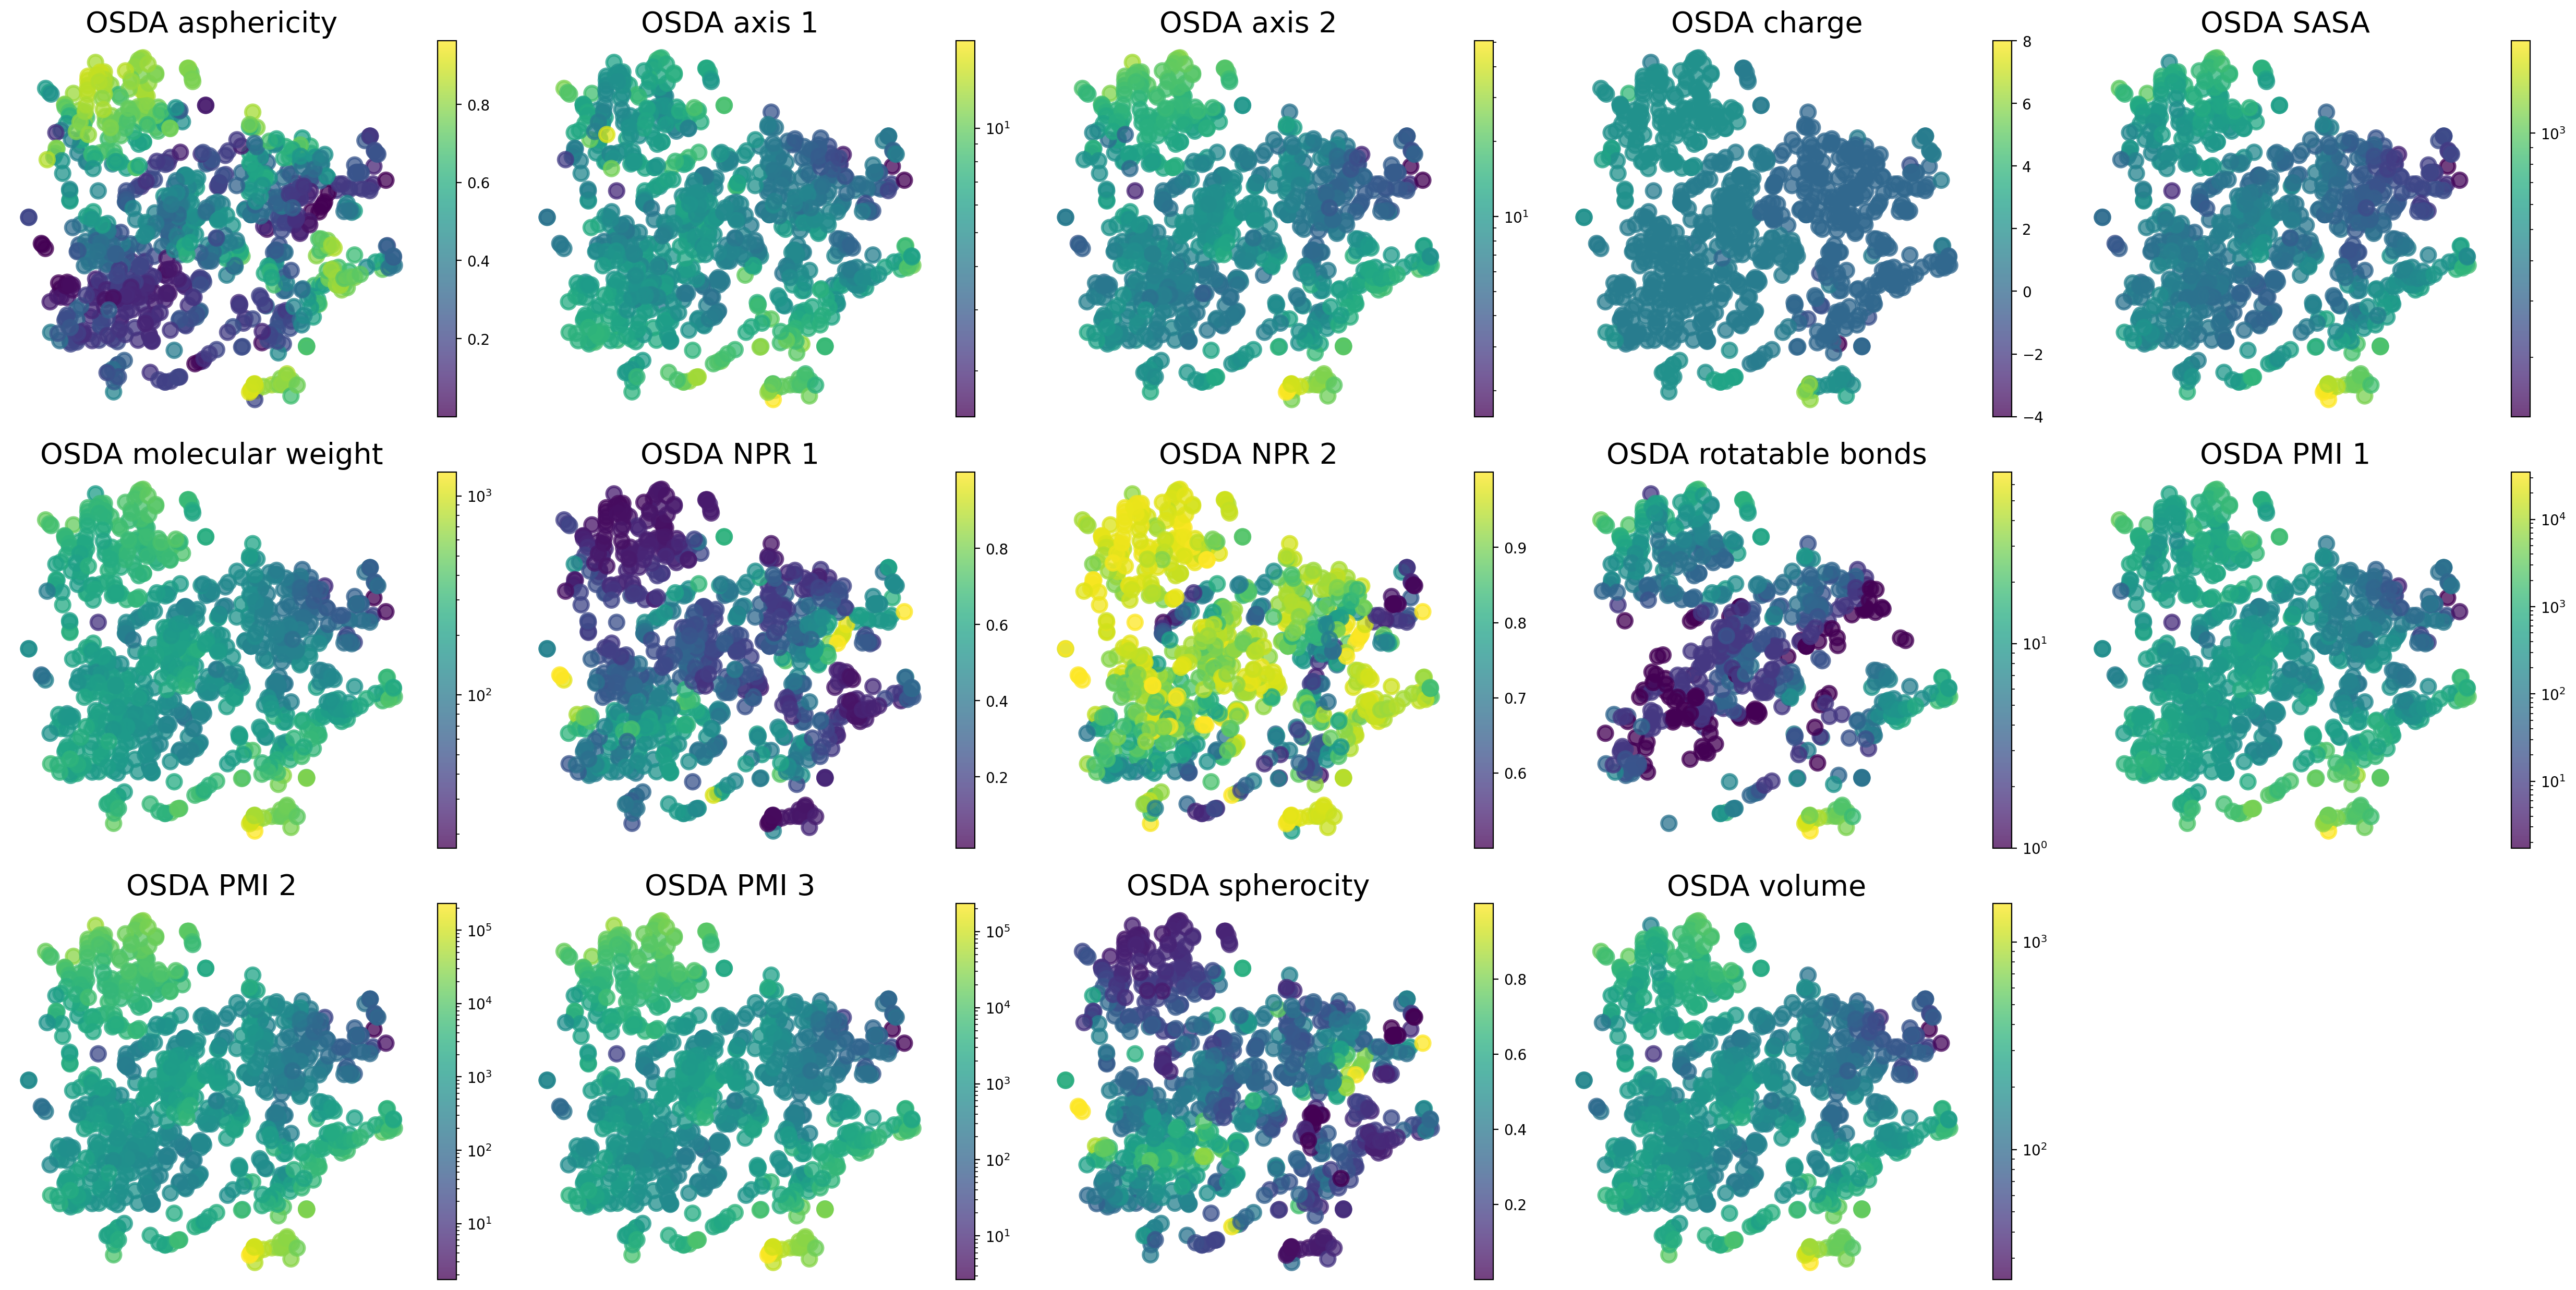

In [7]:
fig = plt.figure(figsize=(25, 8 * 15), dpi=200)

for i, osda_col in enumerate(osda_cols.keys()):
    ax = fig.add_subplot(29, 5, i+1)
    
    if osda_col in ['asphericity_mean_0', 'formal_charge', 'npr1_mean_0', 'npr2_mean_0', 'spherocity_index_mean_0']:
        norm = None
    else:
        norm=LogNorm()

    plt.scatter(df_osda_emb['t-SNE 1'], df_osda_emb['t-SNE 2'], marker='o', s=100, c=df_osda_emb[osda_col], linewidth=2, cmap='viridis', alpha=0.75,
                norm=norm, 
                )
    cb = plt.colorbar()
    plt.xlabel('t-SNE 1', fontsize=20)
    plt.ylabel('t-SNE 2', fontsize=20)
    plt.title(osda_cols[osda_col], fontsize=20)
    ax.set_axis_off()
plt.tight_layout()
plt.show()